# Satellite image - Sentinel 2

## Raster processing

This jupyter notebook shows how to load and combine **Sentinel-2** JPEG band satellite images to create a raster composite. It also exemplifies how to use several libraries (e.g. ***geopandas***, ***shapely***, ***rioxarray***) to clip raster data via a shapefile mask.  

*The example shown here takes the province of Utrecht in the Netherlands.* 

*First, we load up the **Sentinel-2** tile that covers the whole province and then we create a **mask** shapefile of the province out of the country shapefile. Later on, we finish by parsing the bands from **tiff** into ***numpy*** arrays, stacking them up, and making a **RGB** composite, displaying the results.* 

---

Let's start loading the necessary libraries:

In [1]:
# importing necessary libraries
import rasterio
from rasterio.merge import merge
from rasterio import plot
import numpy as np
import matplotlib.pyplot as plt

### Loading imagery

To load up the image, let's take the path directory where all bands are located and use it here as a standard path:

In [2]:
# Getting path directory
imagePath = "./data/"

We are going to load each band using the rasterio library. For now, we are taking only **bands 2**, **3**, **4** and **8**.

**Important remark - Sentinel-2 satellite imagery have RGB bands corresponding to:<br>
Band 4 - Red<br>
Band 3 - Green<br>
Band 2 - Blue**

In [3]:
# Using path directory to load each band
band2_uft = rasterio.open(imagePath+'T31UFT_20200420T105031_B02_10m.jp2', driver='JP2OpenJPEG') #blue
band3_uft = rasterio.open(imagePath+'T31UFT_20200420T105031_B03_10m.jp2', driver='JP2OpenJPEG') #green
band4_uft = rasterio.open(imagePath+'T31UFT_20200420T105031_B04_10m.jp2', driver='JP2OpenJPEG') #red

### Parsing satellite image bands and making a composite

Now, we are going to create a raster composite also using the ***rasterio*** library. We parse the three bands and write the new raster into a **GTiff** format.  

In [4]:
#creating a new tiff composite
trueColor_uft = rasterio.open(imagePath+'S2A_MSIL2A_20200420T105031_N0214_R051_T31UFT_TRUECOLOR.tiff','w',driver='GTiff',
                         width=band4_uft.width, height=band4_uft.height,
                         count=3,
                         crs="+proj=utm +zone=31 +ellps=WGS84 +units=m +no_defs ",
                         transform=band4_uft.transform,
                         dtype=band4_uft.dtypes[0]
                         )
# parsing bands RGB
trueColor_uft.write(band4_uft.read(1),1) #red
trueColor_uft.write(band3_uft.read(1),2) #green
trueColor_uft.write(band2_uft.read(1),3) #blue
trueColor_uft.close()

We can see the result with rasterio, opening the tiff file we just created and plotting the **Band 1** just to test.

In [5]:
# opening the new raster image
truecolor_nl = rasterio.open(imagePath+'S2A_MSIL2A_20200420T105031_N0214_R051_T31UFT_TRUECOLOR.tiff',driver='Gtiff')

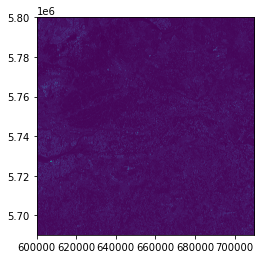

<AxesSubplot:>

In [6]:
# plotting band 1
rasterio.plot.show((truecolor_nl,1))

---

## Geopandas

Geopandas is a library extendend from ***Pandas***. It makes use of pandas functionalities with the addition of spatial operations on geometry datatypes. 

As we are using the Netherlands as an example, we can take the shapefile of the Dutch provincies and filter the province of Utrecht, so we can use it to clip our raster dataset (composite that we created above).

### Provinces - Polygon shapefile

In [7]:
# Let's import pandas and geopandas
import pandas as pd
import geopandas

PROJ: proj_create_from_database: Cannot find proj.db


Loading polygon shapefile dataset using geopandas.

In [8]:
provinces = geopandas.read_file(imagePath+'Provinces_Netherlands.shp')

We can visualize the head of the dataset.

In [9]:
provinces.head()

,provincien,geometry
0,Gelderland,"POLYGON ((181361.527 418255.386, 181300.000 41..."
1,Fryslân,"POLYGON ((189491.268 535832.617, 189485.607 53..."
2,Zuid-Holland,"POLYGON ((77420.225 406769.875, 77418.720 4067..."
3,Overijssel,"POLYGON ((248291.900 459808.449, 248265.470 45..."
4,Noord-Brabant,"MULTIPOLYGON (((167891.450 359190.720, 167886...."


In [10]:
provinces.shape

(12, 2)

We saw that we have 12 rows in this shapefile, then a total of 12 Dutch provinces.

As we do not have too many rows, let's see our entire dataset, so we can see the province of Utrecht.

In [11]:
provinces

,provincien,geometry
0,Gelderland,"POLYGON ((181361.527 418255.386, 181300.000 41..."
1,Fryslân,"POLYGON ((189491.268 535832.617, 189485.607 53..."
2,Zuid-Holland,"POLYGON ((77420.225 406769.875, 77418.720 4067..."
3,Overijssel,"POLYGON ((248291.900 459808.449, 248265.470 45..."
4,Noord-Brabant,"MULTIPOLYGON (((167891.450 359190.720, 167886...."
5,Groningen,"POLYGON ((265275.541 549247.459, 265225.386 54..."
6,Limburg,"POLYGON ((199549.696 308385.049, 199543.314 30..."
7,Noord-Holland,"POLYGON ((131700.944 464257.265, 131697.811 46..."
8,Zeeland,"POLYGON ((50235.786 357928.267, 50235.440 3579..."
9,Utrecht,"POLYGON ((131894.470 429932.357, 131879.057 42..."


With geopandas we can also see the coordinate system information about the shapefile.

In [12]:
# checking the coordinate system
provinces.crs

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

We can use ***matplotlib.pyplot*** to plot the shapefile. ***Let's see the Netherlands and its provinces!***

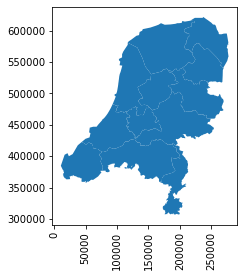

In [13]:
# plotting the polygon shapefile
provinces.plot()
plt.xticks(rotation=90);

We can see what type of geometry we have available in this data.

In [14]:
# retrieving the geometry column
provinces.geometry

0     POLYGON ((181361.527 418255.386, 181300.000 41...
1     POLYGON ((189491.268 535832.617, 189485.607 53...
2     POLYGON ((77420.225 406769.875, 77418.720 4067...
3     POLYGON ((248291.900 459808.449, 248265.470 45...
4     MULTIPOLYGON (((167891.450 359190.720, 167886....
5     POLYGON ((265275.541 549247.459, 265225.386 54...
6     POLYGON ((199549.696 308385.049, 199543.314 30...
7     POLYGON ((131700.944 464257.265, 131697.811 46...
8     POLYGON ((50235.786 357928.267, 50235.440 3579...
9     POLYGON ((131894.470 429932.357, 131879.057 42...
10    POLYGON ((157694.139 473920.680, 156333.300 47...
11    POLYGON ((231251.923 518241.166, 231249.669 51...
Name: geometry, dtype: geometry

Later on, we will clip our raster data for the province of Utrecht, so we can grab the info from Utrecht in the polygon shapefile.

In [15]:
# selecting only Utrecht
utrecht = provinces[provinces['provincien'] == 'Utrecht']

In [16]:
# checking our filter result
utrecht

,provincien,geometry
9,Utrecht,"POLYGON ((131894.470 429932.357, 131879.057 42..."


Checking the visual result is also very important. Let's plot our new **utrecht** variable.

<AxesSubplot:>

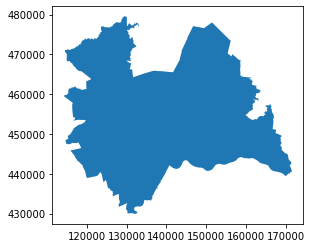

In [17]:
# plotting the province of Utrecht
utrecht.plot()

We can save to disk this new shapefile using ***geopandas***.

In [18]:
utrecht.to_file(imagePath+'utrecht.shp',driver='ESRI Shapefile')

Just for example purposes, we can also use ***geopandas*** to read this newly created shapefile of the Utrecht province.

In [19]:
# reading shapefile
utrecht_shp = geopandas.read_file(imagePath+'utrecht.shp')

<AxesSubplot:>

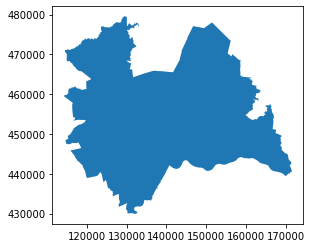

In [20]:
# plotting for check purposes
utrecht_shp.plot()

In [21]:
# retrieving CRS info
utrecht_shp.crs

<Projected CRS: PROJCS["Amersfoort_RD_New",GEOGCS["GCS_Amersfoort" ...>
Name: Amersfoort_RD_New
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

---

## Clipping Raster

Now that we saw some basic ***geopandas*** features to manipulate geospatial data, let's take our utrecht shapefile and clip the raster dataset.

In [22]:
# importing necessary libraries
import os
import rioxarray as rxr
from shapely.geometry import mapping

# making sure that rioxarray can access the correct GDAL python libraries
os.environ['PROJ_LIB'] = 'C:\\Users\\JoseCirillo\\anaconda3\\envs\\my_env\\Library\\share\\proj'
os.environ['GDAL_DATA'] = 'C:\\Users\\JoseCirillo\\anaconda3\\envs\\my_env\\Library\\share'

In [23]:
# opening the dataset with rioxarray
truecolor_nl = rxr.open_rasterio(imagePath+'S2A_MSIL2A_20200420T105031_N0214_R051_T31UFT_TRUECOLOR.tiff',masked=True).squeeze()

Now it is time to clip our raster dataset using the Utrecht shapefile as mask.

*If our mask shapefile is in a different CRS than the raster data, then we need to make sure to give the first the same CRS from our raster. In our example we have:<br>*

**Utrecht shapefile -** ***EPSG:28992***<br>
**Raster data -** ***EPSG:32631***

In [24]:
# clipping raster data with polygon shapefile
tiff_clipped = truecolor_nl.rio.clip(utrecht_shp.geometry.apply(mapping),
                                      # applying the intended CRS to the raster data
                                      utrecht_shp.crs)

In [25]:
# checking the clipped tiff CRS
tiff_clipped.rio.crs

CRS.from_epsg(32631)

Now that we have our clipped raster data, we can write it to disk, once again using ***rioxarray*** library.

In [26]:
# writing clipped raster data to disk
tiff_clipped.rio.to_raster(imagePath+'clipped_S2A_MSIL2A_20200420T105031_N0214_R051_T31UFT_TRUECOLOR.tiff')

---

## Visualizing the results (Clipped Raster)

Last but not least, we can visualize our results, plotting the clipped raster data of the province of Utrecht.

In [27]:
# opening the dataset with rasterio
utrecht_tiff = rasterio.open(imagePath+'clipped_S2A_MSIL2A_20200420T105031_N0214_R051_T31UFT_TRUECOLOR.tiff',driver='Gtiff')

Examples of retrieving relevant information about our raster are height, width, shape.

In [28]:
utrecht_tiff.height

4955

In [29]:
utrecht_tiff.width

5797

In [30]:
utrecht_tiff.shape

(4955, 5797)

*In order to better display our true color composite, we have to scale each band, by doing this we are able to increase the visual contrast of the image. It is important to point out that this simple ***scaling math*** is only applied here for ***visual purposes*** and not to change the true value of each pixel and use these further in other processing activities.*

After scaling all bands, we have to parse each band into numpy arrays, so we can properly display the tiff file.

In [31]:
# scaling raster values for display purposes
def scale(band):
    return band / 2000.0

# Loading each band into numpy arrays
red = scale(utrecht_tiff.read(1))
green = scale(utrecht_tiff.read(2))
blue = scale(utrecht_tiff.read(3))

### Let's finally plot our true color raster showing the province of Utrecht in the Netherlands.

At this moment, we have each band as a ***numpy*** array, so we can stack them up and display an **RGB** image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 5796.5, 4954.5, -0.5)

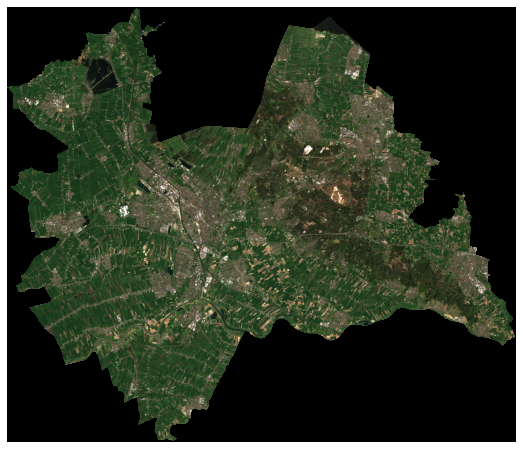

In [32]:
rgb = np.dstack((red, green, blue))
# plot the RGB stack to see a true-color representation
plt.figure(figsize=(10,8))
plt.imshow(rgb)
plt.axis('off')

We can also visualize each band through ***matplotlib.pyplot*** library. Let's see some final and quick examples.

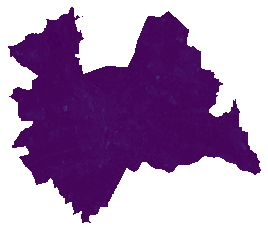

In [33]:
# Loading only the blue band.
fig = plt.imshow(blue)
plt.axis('off')
# Displaying the results
plt.show()

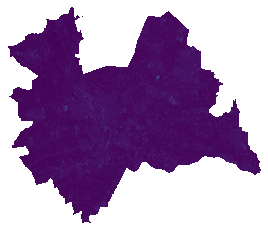

In [34]:
# Loading only the red band.
fig = plt.imshow(red)
plt.axis('off')
# Displaying the results
plt.show()

It is also possible to plot one band using a built-in **colormap**. Our example here shows the green band using the **gist_earth** colormap available from ***matplotlib***, as well as a color bar.

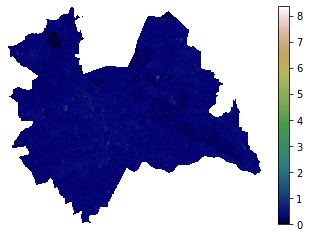

In [35]:
# Visualizing the green band with a non-default colormap
fig = plt.imshow(green)
fig.set_cmap('gist_earth')
plt.colorbar()
plt.axis('off')
# Displaying the results.
plt.show()